# Imports and Reading Data

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [20]:
import pandas as pd
import numpy as np

import nltk
import re

from wordcloud import WordCloud

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Downloading all the requirements
# !pip install scikit-multilearn
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('stopwords')

# !pip install contractions
import contractions

from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import NuSVC, SVC

from sklearn.pipeline import Pipeline, make_union
from sklearn.metrics import roc_auc_score, f1_score
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.model_selection import cross_val_score

from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.combine import SMOTEENN, SMOTETomek

# !pip install -U imbalanced-learn

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# Setting global parameters for the Plots
rcParams['figure.figsize'] = 18, 9 
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['lines.linewidth'] = 2.5
rcParams['xtick.labelsize'] = 'smaller'
rcParams['ytick.labelsize'] = 'smaller'
rcParams['axes.labelpad'] = 15

In [3]:
# Read the data
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

labels = ['harsh', 'extremely_harsh', 'vulgar', 'threatening', 'disrespect', 'targeted_hate']

# Preprocessing

### Basic text preprocessing





1.   Remove URLs, HTML Tags, Non-Alphanumeric characters, extra whitespaces, lowercase
2.   Lemmatize
3.   Remove Stopwords
4.   Remove words with length <= 2
5.   Fix Contractions

In [4]:
class preprocess:

    def __init__(self):
        pass

    def clean(self, df, column):
      
        # applying all the methods in sequence
        df[column] = df[column].str.lower()
        df[column] = self.fix_contractions(df, column)

        # df[column] = df[column].apply(self.rm_decontracted)
        df[column] = df[column].apply(self.rm_urls)
        df[column] = df[column].apply(self.rm_html_tags)
        df[column] = df[column].apply(self.rm_non_alpha)
        # df[column] = self.rm_stopwords(df, column)

        # df[column] = df[column].apply(self.rm_patterns_removal) #ZZZZZZ REMOVER
        df[column] = df[column].apply(self.rm_repeated_text) ### ZZZZ TO Z
        df[column] = df[column].apply(self.rm_numword_removal)
        df[column] = self.rm_whitespace(df, column)

        # lowercasing the text


        df = self.lemmatization(df, column)
        # df[column] = self.rm_stopwords(df, column)
        # df = self.remove_less_2(df, column)
    
        return df

    def rm_urls(self, text):
        return re.sub(r'http\S+', ' ', text)
    
    def rm_html_tags(self, text):
        clean = re.compile('<.*?>')
        return re.sub(clean, ' ', text)

    def rm_non_alpha(self, text):
        return re.sub('[^a-zA-Z]', ' ', text)

    def rm_whitespace(self, df, column):
        return df[column].apply(lambda x : " ".join(x.split()))

    def lemmatization(self, df, column):
        lemma = WordNetLemmatizer()

        # Lemmatizing with respect to the verb form and noun form
        df[column] = df[column].apply(lambda x : " ".join([lemma.lemmatize(word = w, pos='v') for w in x.split(" ")]))
        df[column] = df[column].apply(lambda x : " ".join([lemma.lemmatize(word = w, pos='n') for w in x.split(" ")]))

        # df[column] = df[column].apply(lambda x : " ".join([lemma.lemmatize(word = w, pos='a') for w in x.split(" ")]))	
        # df[column] = df[column].apply(lambda x : " ".join([lemma.lemmatize(word = w, pos='r') for w in x.split(" ")]))	
        # df[column] = df[column].apply(lambda x : " ".join([lemma.lemmatize(word = w, pos='s') for w in x.split(" ")]))		

        return df

    def rm_stopwords(self, df, column):

        # Generating all the stop words of english and removing no,not nor as they are significantly important
        stop = stopwords.words('english')
        not_stop_words = {'no', 'not', 'nor','very','but'}
        modified_stop = [ele for ele in stop if ele not in not_stop_words]

        return df[column].apply(lambda x : ' '.join([word for word in x.split(' ') if word not in modified_stop]))

    # As the words with less than length 2 will not contribute to toxicity in a general manner
    def _clean_small(self, text):
        return re.sub(r'\b\w{1,2}\b', '', text)

    # After every re.sub we get varied amount of whitespaces so it is essential to remove white spaces
    def remove_less_2(self, df, column):
        df[column] = df[column].apply(self._clean_small)
        df[column] = self.rm_whitespace(df, column)
        return df

    # zzzzzzzzzz remover
    def rm_patterns_removal(self,text): 
        return re.sub("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b",' ',text)

    #function to remove words with numbers
    def rm_numword_removal(self,text):
        return re.sub("\S*\d\S*", " ", text).strip()

    def rm_decontracted(self,text):
      phrase = re.sub(r"\'t", " not", text)
      phrase = re.sub(r"\'re", " are", phrase)
      phrase = re.sub(r"\'s", " is", phrase)
      phrase = re.sub(r"\'d", " would", phrase)
      phrase = re.sub(r"\'ll", " will", phrase)
      phrase = re.sub(r"\'ve", " have", phrase)
      phrase = re.sub(r"\'m", " am", phrase)
      return phrase

    # zzzzzzzzzz updater to z remover
    def rm_repeated_text(self,text):
      return re.sub(r'(.)\1{2,}', r'\1', text) 

    def fix_contractions(self, df, column):
        return df[column].apply(contractions.fix)

In [5]:
df_train = preprocess().clean(df_train, 'text')
df_test = preprocess().clean(df_test, 'text')

# EDA (Exploratory Data Analysis)

### Count of comments per category

To get a better sense of our MultiLabel Classification we would start by plotting the number of texts in each category.

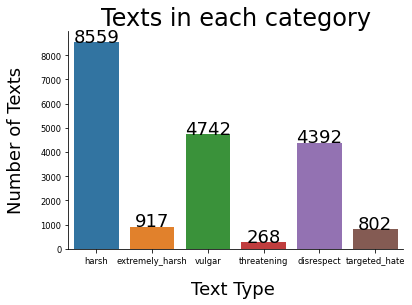

In [6]:
# List all the target columns
categories = list(df_train.columns.values)
categories.remove('id')
categories.remove('text')

#Plot
ax = sns.barplot(x=categories, y=df_train.iloc[:, 2:].sum().values)

#Labelling
plt.title("Texts in each category", fontsize=24)
plt.ylabel('Number of Texts', fontsize=18)
plt.xlabel('Text Type ', fontsize=18)

#For accessing the subplots in the graph
rects = ax.patches

category_values = df_train.iloc[:, 2:].sum().values

#For each subplot we need to assign a x coordinate, y coordinate and label with the orientation and fontsize
for rect, label in zip(rects, category_values):
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), label, ha='center', fontsize=18)

plt.show()

**Observation**: Our dataset has severe class imbalance. Most conventional classification algorithms perform badly on imbalanced datasets.

### Count of comments with multiple labels

Now let us count the number of comments having multiple labels.

In [7]:
# Finding the rows which correspond to the toxic comments by looking at the toxic column's values.
df_toxic = df_train[(df_train[['harsh', 'extremely_harsh', 'vulgar', 'threatening', 'disrespect', 'targeted_hate']] > 0).any(axis=1)]
len(df_toxic)

9076

There are only 9076 "Toxic comments" out of 89,359 total comments.

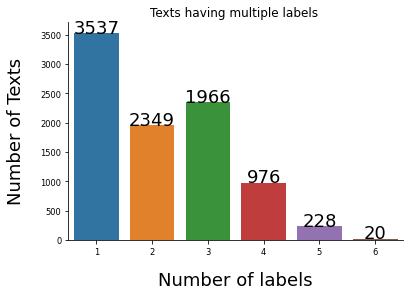

In [8]:
#Sums of the toxic columns for each row
rowSums = df_train.iloc[:, 2:].sum(axis=1)

# corresponding value counts for number of toxic labels
multiLabel_counts = rowSums.value_counts()

#Taking all the non-zero aka toxic comments counts only
multiLabel_counts = multiLabel_counts.iloc[1:]

ax = sns.barplot(x=multiLabel_counts.index, y=multiLabel_counts.values)

plt.title("Texts having multiple labels ")
plt.ylabel('Number of Texts', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)

# adding the text labels
rects = ax.patches
category_values = multiLabel_counts.values

for rect, label in zip(rects, category_values):
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), label, ha='center', fontsize=18)
            
plt.show()

**Observations**: All 6 labels at the same time is extremely rare and only one label takes up the majority.

### Top words

Now, let us find the top 100 words by frequency (for toxic comments only)

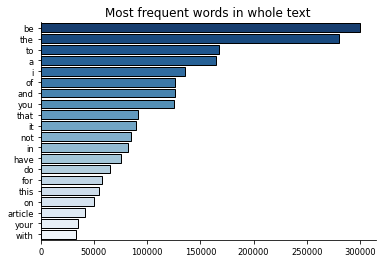

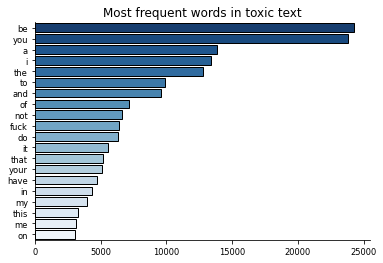

In [9]:
# value counts of each word in all the sentences.
list_words = pd.Series(' '.join(df_train.text).lower().split()).value_counts()
toxic_words = pd.Series(' '.join(df_toxic.text).lower().split()).value_counts()

sns.barplot(y=list_words.iloc[:20].index, x=list_words.iloc[:20].values, palette='Blues_r', edgecolor="k", linewidth=1)
plt.title("Most frequent words in whole text")
plt.show()

ax = sns.barplot(y=toxic_words.iloc[:20].index, x=toxic_words.iloc[:20].values, palette='Blues_r', edgecolor="k", linewidth=1)
plt.title("Most frequent words in toxic text")
plt.show()

**Observation**: "Clean" words are more frequent than "Toxic" words. This was expected because only about 10% comments are toxic.

### Wordcloud

Let us make a WordCloud to better understand the occurrences of the words which constitute in the majority.

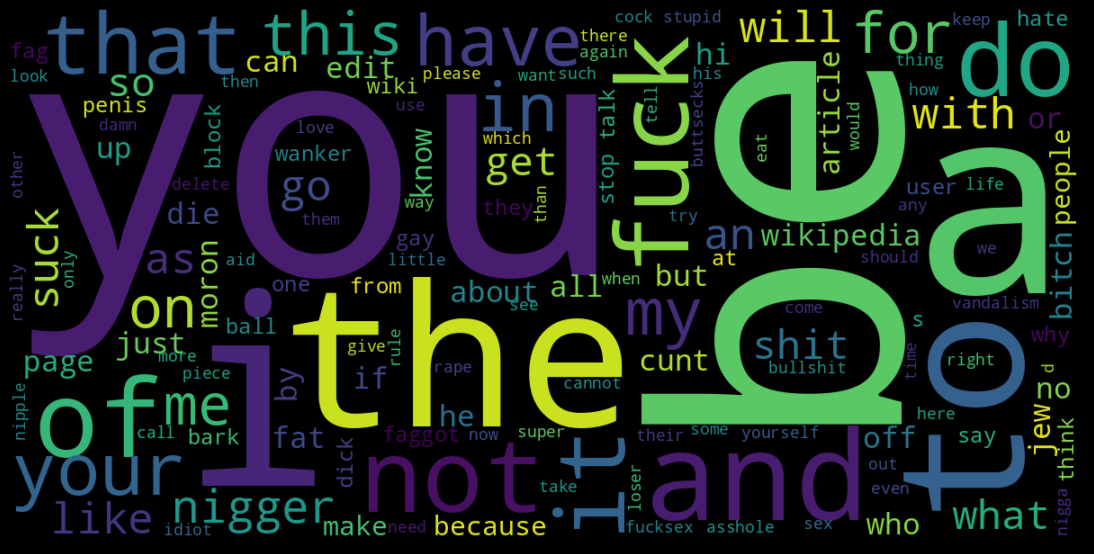

In [10]:
def generate_word_cloud(text):
    wordcloud = WordCloud(background_color = 'black', scale=3, max_words=150).generate_from_frequencies(text)

    fig = plt.figure(figsize = (15, 15), facecolor = 'black', edgecolor = 'black')
    
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

generate_word_cloud(toxic_words)

### Length of Comments

Next, we will plot the length of comments. We can observe that most comments are less than 100 words long.

Text(0, 0.5, 'Count of Comments')

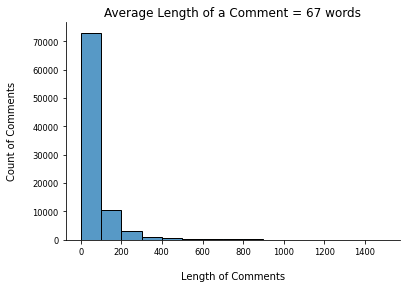

In [11]:
text_len = df_train.text.str.split().str.len()

plt.title("Average Length of a Comment = " + str(int(text_len.mean())) + " words")
# plt.xticks(range(0, 5000+1, 500))

ax = sns.histplot(text_len, binwidth=100)
ax.set_xlabel('Length of Comments')
ax.set_ylabel('Count of Comments')

# Model Selection and Training

In [16]:
# For training full train data

X_train = df_train['text'].to_numpy()
Y_train = df_train.drop(columns=["id", "text"]).to_numpy()
X_test = df_test['text'].to_numpy()

In [13]:
# # For testing purposes, split training data into train and test
# # Here we are using iterative_train_test_split for stratified multi-label split

# Y = df_train.drop(columns=["id", "text"]).to_numpy()
# X = df_train.iloc[:, :2].to_numpy()
# X_train, Y_train, X_test, Y_test = iterative_train_test_split(X, Y, test_size = 0.1)
# X_train = X_train[:, 1]
# X_test = X_test[:, 1]
# X_test = df_test['text'].to_numpy()

### Tf-idf (words) + Tf-idf (chars)

In [17]:
vectorizer_word = TfidfVectorizer(binary=True, max_features=30000, dtype=np.float32)
vectorizer_char = TfidfVectorizer(binary=True, analyzer='char', max_features = 30000, ngram_range=(1, 4), dtype=np.float32)

vectorizer = make_union(vectorizer_word, vectorizer_char, n_jobs=-1)
vectorizer

FeatureUnion(n_jobs=-1,
             transformer_list=[('tfidfvectorizer-1',
                                TfidfVectorizer(binary=True,
                                                dtype=<class 'numpy.float32'>,
                                                max_features=30000)),
                               ('tfidfvectorizer-2',
                                TfidfVectorizer(analyzer='char', binary=True,
                                                dtype=<class 'numpy.float32'>,
                                                max_features=30000,
                                                ngram_range=(1, 4)))])

In [18]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

### Naive Bayes

In [107]:
NB = []
CVR = []
for i in range(len(labels)):
	NB.append(MultinomialNB(alpha=0.04))
	CVR.append(cross_val_score(NB[i], X_train, Y_train[:, i], cv=5, n_jobs=-1, scoring="roc_auc"))
	NB[i] = NB[i].fit(X_train, Y_train[:, i])

print("CV_SCORE - ", np.array([i.mean() for i in CVR]).mean())

CV_SCORE -  0.956268770821925


### Logistic Regression without Sampling

In [85]:
LR = []
CVR = []
for i in range(len(labels)):
	LR.append(LogisticRegression(max_iter=1000, C=1.2))
	CVR.append(cross_val_score(LR[i], X_train, Y_train[:, i], cv=5, n_jobs=-1, scoring="roc_auc"))
	LR[i] = LR[i].fit(X_train, Y_train[:, i])

print("CV_SCORE - ", np.array([i.mean() for i in CVR]).mean())

CV_SCORE -  0.9848657106580413


### Logistic Regression with Sampling -

In [105]:
param_C = [1.4, 1.3, 1.1, 1.3, 0.7, 1.1]	# value for parameter C for each class
x = [X_train for i in range(len(labels))]
y = [Y_train[:, i] for i in range(len(labels))]

# Applying Oversampling and Undersampling for label 1 and 3
x[1], y[1] = RandomOverSampler(random_state=1, sampling_strategy=0.15).fit_resample(X_train, Y_train[:, 1])
x[1], y[1] = RandomUnderSampler(random_state=0, sampling_strategy=1).fit_resample(x[1], y[1])

x[3], y[3] = RandomOverSampler(random_state=0, sampling_strategy=0.18).fit_resample(X_train, Y_train[:, 3])
x[3], y[3] = RandomUnderSampler(random_state=0, sampling_strategy=1).fit_resample(x[3], y[3])

In [102]:
LRS = []
CVR = []
for i in range(len(labels)):
	LRS.append(LogisticRegression(max_iter=1000, C=param_C[i]))
	CVR.append(cross_val_score(LRS[i], x[i], y[i], cv=5, n_jobs=-1, scoring="roc_auc"))
	LRS[i] = LRS[i].fit(x[i], y[i])

print("CV_SCORE - ", np.array([i.mean() for i in CVR]).mean())

CV_SCORE -  0.9877318886860572


In [103]:
# inference
Y_test_pred= np.ones((X_test.shape[0], Y_train.shape[1]))

for i in range(len(labels)):
  Y_test_pred[:, i] = LRS[i].predict_proba(X_test)[:, 1]

## Classifier Chains

In [ ]:
# vectorizer = TfidfVectorizer(binary=True, max_features=30000)
# x_train = vectorizer.fit_transform(X_train)
# x_test = vectorizer.transform(X_test)

In [ ]:
chains = [ClassifierChain(LogisticRegression(max_iter=1000), order="random", random_state=i) for i in range(10)]
for chain in chains:
    chain.fit(x_train, Y_train)

NameError: ignored

In [ ]:
Y_pred_chains = np.array([chain.predict_proba(x_test) for chain in chains])
Y_pred_ensemble = Y_pred_chains.mean(axis=0)

print("Test Data (ensemble) - ", roc_auc_score(y_true=Y_test, y_score=Y_pred_ensemble))

for i in range(10):
    print("Test Data - ", roc_auc_score(y_true=Y_test, y_score=Y_pred_chains[i]))

## Grid Search for TFIDF parameters

In [ ]:
# from pprint import pprint
# from time import time
# import logging

# from sklearn.model_selection import GridSearchCV

# parameters = {
#     "tfidf__binary": (True, False),
#     "tfidf__max_df": (0.5, 0.75, 1.0),
#     'tfidf__max_features': (None, 25000, 30000, 35000, 40000),
#     "tfidf__ngram_range": ((1, 1), (1, 2), (2, 2)),  # unigrams or bigrams
#     # 'tfidf__use_idf': (True, False),
#     # 'tfidf__norm': ('l1', 'l2'),
#     # "clf__max_iter": (20,),
#     # "clf__alpha": (0.00001, 0.000001),
#     # "clf__penalty": ("l2", "elasticnet"),
#     # 'clf__max_iter': (10, 50, 80),
# }

# grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=3, scoring='roc_auc')

# print("Performing grid search...")
# print("pipeline:", [name for name, _ in pipeline.steps])
# print("parameters:")
# pprint(parameters)
# t0 = time()
# grid_search.fit(X_train, Y_train)
# print("done in %0.3fs" % (time() - t0))
# print()

# print("Best score: %0.3f" % grid_search.best_score_)
# print("Best parameters set:")
# best_parameters = grid_search.best_estimator_.get_params()
# for param_name in sorted(parameters.keys()):
#     print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
# grid_search.cv_results_

In [ ]:
# pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score')

### GridSearchCV

In [ ]:
# param_grid = [    
#     {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
#     'C' : np.logspace(-4, 4, 20),
#     'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
#     'max_iter' : [100, 1000,2500, 5000]
#     }
# ]

In [ ]:
# import warnings
# warnings.filterwarnings("ignore")

# clf = GridSearchCV(LogisticRegression(), param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1,scoring = 'roc_auc')

# GSCV = []

# #Making LR list for all the 6 target columns and applying logistic regression on all of them considering they are independent  
# for i in range(Y_train.shape[1]):
#   print(i)
#   best_clf=clf.fit(X_train, Y_train[:, i])
#   # GSCV.append(clf.fit(X_train, Y_train[:, i]))
#   print("END")
#   print(best_clf.best_estimator_)

In [ ]:
# Y_train_pred_prob = np.ones((Y_train.shape[0], Y_train.shape[1]))

# for i in range(Y_train.shape[1]):
#   Y_train_pred_prob[:, i] = LR[i].predict_proba(X_train)[:, 1]

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# pipeline for Random Forest
pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(binary=True, max_features=30000)), 
                ('clf', RandomForestClassifier(max_depth=100, n_estimators=200, max_samples=0.5, n_jobs=-1)),
            ])

# training the pipeline
pipeline.fit(X_train, Y_train)

# predicting label probability
Y_train_pred = pipeline.predict_proba(X_train)
# Y_train_pred_labels = pipeline.predict(X_train)
Y_test_pred = pipeline.predict_proba(X_test)


# We can use RandomForest without OneVsRest too. Uncomment the following code if so

temp = np.ones((Y_train.shape[0], Y_train.shape[1]))
for i in range(6):
    temp[:, i] = Y_train_pred[i][:, 1]
Y_train_pred = temp

temp = np.ones((Y_test.shape[0], Y_test.shape[1]))
for i in range(6):
    temp[:, i] = Y_test_pred[i][:, 1]
Y_test_pred = temp

# calculating metrics
print("Train Data - ", roc_auc_score(y_true=Y_train, y_score=Y_train_pred))
print("Test Data - ", roc_auc_score(y_true=Y_test, y_score=Y_test_pred))

Train Data -  0.9986142736364688
Test Data -  0.9745953126461658


: 

## XGBoost

In [ ]:
# import xgboost as xgb

# XGBarray = []

# #Making LR list for all the 6 target columns and applying logistic regression on all of them considering they are independent  
# for i in range(Y_train.shape[1]):
#   print(i)
#   XGBarray.append(xgb.XGBClassifier().fit(X_train, Y_train[:, i]))

In [ ]:
# Y_train_pred_prob = np.ones((Y_train.shape[0], Y_train.shape[1]))

# for i in range(Y_train.shape[1]):
#   Y_train_pred_prob[:, i] = XGBarray[i].predict_proba(X_train)[:, 1]

In [ ]:
# roc_auc_score(y_true=Y_train, y_score=Y_train_pred_prob)

In [ ]:
# Y_test_pred_prob = np.ones((X_test.shape[0], Y_train.shape[1]))

# for i in range(Y_train.shape[1]):
#   Y_test_pred_prob[:, i] = XGBarray[i].predict_proba(X_test)[:, 1]

In [ ]:
# roc_auc_score(y_true=Y_test, y_score=Y_test_pred_prob)

## BERT MODEL

In [ ]:
!pip install spacy-transformers
!python -m spacy download en_core_web_trf
!python -m spacy download en_trf_bertbaseuncased_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2022-11-04 06:47:21.163506: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 460.3 MB 22 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')
2022-11-04 06:48:24.807223: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

✘ No compatible package found for 'en_trf_bertbaseuncased_lg' (spaCy
v3.4.2)



In [ ]:
!pip install -U spacy[cuda92,transformers]
!export CUDA_PATH=”/usr/local/cuda-9.2"
!export LD_LIBRARY_PATH=$CUDA_PATH/lib64:$LD_LIBRARY_PATH
!pip install cupy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55.0 MB 78 kB/s 
/bin/bash: -c: line 0: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 1: syntax error: unexpected end of file
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 7.4 MB/s 
ERROR: Operation cancelled by user
^C


In [ ]:
import spacy
import torch
nlp = spacy.load("en_trf_bertbaseuncased_lg")
# nlp = spacy.load("en_core_web_trf")

ValueError: ignored

In [ ]:
from sklearn import svm
from sklearn.metrics import roc_auc_score

docs = [nlp(text) for text in X_train]
train_x_vectors = [doc.vector for doc in docs]
SVM =[]

for i in range(Y_train.shape[1]):
    SVM.append(svm.SVC(kernel='linear').fit(train_x_vectors, Y_train[:, i]))


Y_train_pred_prob = np.ones((Y_train.shape[0], Y_train.shape[1]))

for i in range(Y_train.shape[1]):
    Y_train_pred_prob[:, i] = SVM[i].predict_proba(train_x_vectors)[:, 1]

docs = [nlp(text) for text in X_test]
test_x_vectors = [doc.vector for doc in docs]

Y_test_pred_prob = np.ones((Y_train.shape[0], Y_train.shape[1]))

for i in range(Y_train.shape[1]):
    Y_test_pred_prob[:, i] = SVM[i].predict_proba(test_x_vectors)[:, 1]

# test_x = ["check this story out"]
# docs = [nlp(text) for text in X_test]
# test_x_vectors = [doc.vector for doc in docs]

# clf_svm.predict(test_x_vectors)
roc_auc_score(y_true=Y_train, y_score=Y_train_pred)
# roc_auc_score(y_true=Y_e, y_score=Y_train_pred)

# Exporting test predictions

In [96]:
#Assigning the columns to the obtained data
df_export = pd.DataFrame(data=Y_test_pred, columns=["harsh", "extremely_harsh","vulgar","threatening","disrespect","targeted_hate"])

In [97]:
#appending id in the start
df_export.insert(loc=0, column='id', value=df_test['id'])

In [98]:
#exporting it in the end
df_export.to_csv('prediction.csv',index=False)